In [3]:
#Libraries for math and data manipulation
import numpy as np
import pandas as pd
import math
import numpy.random as rand
import scipy as sp
import sys
from datetime import datetime

#Plotting stuff
import matplotlib.pyplot as plt
import seaborn
import corner
%matplotlib inline
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True) #Want to be able to use tex in the plot labels
seaborn.set_style('ticks')
seaborn.set_color_codes()

#Machine learning stuff
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier   #This is a single decision tree
from sklearn.ensemble import ExtraTreesClassifier #Random forest of trees
import graphviz                                   #This package lets you visualize the tree
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.model_selection import train_test_split

In [9]:
#Read in Stata datafile
data_stata = pd.io.stata.read_stata('../ProjectDef/cnsfinall2.dta')
#Convert to .csv. Now you never need to do this again
data_stata.to_csv('../Data/cns_data.csv')

In [10]:
data_raw = pd.read_csv('../Data/cns_data.csv')            #Using Pandas for data manipulation

In [11]:
#Delete useless columns (like surename, initials, etc.)
data_df = data_raw.drop(['surnamenam','patinit','patientreg','mothinit'],axis=1)

In [12]:
data_df.diag.unique()

array(['malaria', '0.0', 'cereb malaria', 'virus-bacteria', 'bacteremia',
       'bact meningitis', 'virus-other', 'virus-malaria',
       'malaria-bacterial', 'tb', 'virus', 'crypto'], dtype=object)

In [22]:
1

1

In [16]:
#Adding a variable that is just 'month and day' - seems better to capture seasonality.
data_df['month'] = pd.DatetimeIndex(data_df['incdate']).month
data_df['day'] = pd.DatetimeIndex(data_df['incdate']).day
data_df['monthday'] = data_df['month']*30+data_df['day']

In [17]:
#Select input features
clin_df = data_df.loc[:,['glasgtot','blanttot','clinjaund','clinhepato','clinspleno','clinconv','clindehyd',\
                          'clinoedem','clinlymph','clinresp','clinablung','clincyan','clincapref','clincoldext',\
                         'clinearinf','clinanemia','clintonsil','clinorcand','clinhemmor','clinaids',\
                         'abdpain','vom','diar','head','muscle','conv',\
                         'sex','ageyrs','agemth','incdate',\
                         'temp','card','resp','sbp','dbp','weight','height','muac',\
                          'mhhosp', 'mhdevsp', 'mhsickle', 'mhchronstat',\
                         'monthday','dimain',\
                         'diag']] #This is the final diagnosis - will be the 'label'

In [23]:
#Convert the date into a useful value. This just counts the days from the beginning of the dataset 
clin_df['incdate'] = pd.to_datetime(clin_df['incdate'])
clin_df['date'] = (clin_df['incdate'] - clin_df['incdate'].min())  / np.timedelta64(1,'D')

#Mapping yes/no to 1/0
clin_df['clinjaund'] = clin_df.clinjaund.map({'Yes': 1, 'No': 0})
clin_df['clinhepato'] = clin_df.clinhepato.map({'Yes': 1, 'No': 0})
clin_df['clinspleno'] = clin_df.clinspleno.map({'Yes': 1, 'No': 0})
clin_df['clinconv'] = clin_df.clinconv.map({'Yes': 1, 'No': 0})
clin_df['clindehyd'] = clin_df.clindehyd.map({'Yes': 1, 'No': 0})
clin_df['clinoedem'] = clin_df.clinoedem.map({'Yes': 1, 'No': 0})
clin_df['clinlymph'] = clin_df.clinlymph.map({'Yes': 1, 'No': 0})
clin_df['clinresp'] = clin_df.clinresp.map({'Yes': 1, 'No': 0})
clin_df['clinablung'] = clin_df.clinablung.map({'Yes': 1, 'No': 0})
clin_df['clincyan'] = clin_df.clincyan.map({'Yes': 1, 'No': 0})
clin_df['clincapref'] = clin_df.clincapref.map({'Yes': 1, 'No': 0})
clin_df['clincoldext'] = clin_df.clincoldext.map({'Yes': 1, 'No': 0})
clin_df['clinearinf'] = clin_df.clinearinf.map({'Yes': 1, 'No': 0})
clin_df['clintonsil'] = clin_df.clintonsil.map({'Yes': 1, 'No': 0})
clin_df['clinorcand'] = clin_df.clinorcand.map({'Yes': 1, 'No': 0})
clin_df['clinhemmor'] = clin_df.clinhemmor.map({'Yes': 1, 'No': 0})
clin_df['clinaids'] = clin_df.clinaids.map({'Yes': 1, 'No': 0})
clin_df['vom'] = clin_df.vom.map({'Yes': 1, 'No': 0})
clin_df['diar'] = clin_df.diar.map({'Yes': 1, 'No': 0})
clin_df['headache'] = clin_df['head'] #Since 'head' is a function
clin_df['conv'] = clin_df.conv.map({'Yes': 1, 'No': 0})
clin_df['ageym'] = clin_df.ageyrs.astype(float)*12.
clin_df.agemth = clin_df.agemth.astype(float)
clin_df['age'] = clin_df.ageym + clin_df.agemth

#Medical history variables
clin_df['mhhosp'] = clin_df.mhhosp.map({'Yes': 1, 'No':0})


#some slightly more compliated mappings
clin_df['abdpain'] = clin_df.abdpain.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':np.nan})
clin_df['headache'] = clin_df.headache.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})
clin_df['muscle'] = clin_df.muscle.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':np.nan})

clin_df['dimain'] = clin_df.dimain.map({"Cerebral Malaria":0, "Meningoencephalitis":1, "Meningitis":2.,\
                                       "Other":3})

clin_df['mhdevsp'] = clin_df.mhdevsp.map({'OTHER':1, 'GLOBAL DEVELOPMENTAL DELAY':1, 'HYDROCEPHALUS':1,
       'HEARING LOSSES':1, 'MOTOR DEVELOPEMENTAL DELAY':1,
       'SPEECH DEVELOPEMENTAL DELAY':1})

#This coding is going to be important. You'll want to figure out which categories are useful, and which
#are practical.
clin_df['diag'] = clin_df.diag.map({'malaria':0, 'cereb malaria':0,'virus-malaria':0,\
                                    'virus-bacteria':1, 'bacteremia':1,'bact meningitis':1,\
                                    'virus-other':2,'virus':2,'malaria-bacterial':3,\
                                    'tb':4,'crypto':4, '0.0':5})

In [24]:
#A lot of these have very few actual answers. i.e., 'headache.' What happens if you map 'nan' to 'No'?
#This is probably something we'll want to play around with.
values = {'clinjaund':0,'clinhepato':0,'clinaids':0,'clinhemmor':0,'clinorcand':0,'clintonsil':0,'clinearinf':0,\
          'clinresp':0,'clinlymph':0,'clindehyd':0,'clinoedem':0,'clinablung':0,'clincyan':0,'clincapref':0,
          'clincoldext':0, 'mhchronstat':0, 'mhdevsp':0,\
         'conv':0,'abdpain':0,'vom':0,'diar':0,'headache':0,'muscle':0}
clin_df = clin_df.fillna(value=values)

In [26]:
#You really shouldn't use the initial diagnosis as a continuous variable ,
#you need to map it into a set of yes/no question.
clin_df['CMalaria'] = clin_df.dimain.map({0:1,1:0,2:0,3:0})
clin_df['Enceph'] = clin_df.dimain.map({0:0,1:1,2:0,3:0})
clin_df['Mening'] = clin_df.dimain.map({0:0,1:0,2:1,3:0})
clin_df['Other'] = clin_df.dimain.map({0:0,1:0,2:0,3:1})

In [27]:
#Pick the features to classify with.
Xlabels = ['CMalaria','Enceph','Mening','Other',\
                      'headache','age','temp','date',\
                      'clinjaund','clintonsil','clinhepato','clinaids','clinhemmor','clinorcand','clinearinf',\
                      'clinresp','clinlymph','clindehyd','clinoedem','clinablung','clincyan','clincapref',\
                      'glasgtot', 'dbp', 'sbp','resp','card','weight','height','muac',\
                      'mhhosp','mhchronstat', 'mhdevsp',\
                      'conv','abdpain','vom','diar','muscle','monthday'] #This is just for plotting.
X_pd = clin_df.loc[:,['CMalaria','Enceph','Mening','Other',\
                      'headache','age','temp','date',\
                      'clinjaund','clintonsil','clinhepato','clinaids','clinhemmor','clinorcand','clinearinf',\
                      'clinresp','clinlymph','clindehyd','clinoedem','clinablung','clincyan','clincapref',\
                      'glasgtot', 'dbp', 'sbp','resp','card','weight','height','muac',\
                      'mhhosp','mhchronstat', 'mhdevsp',\
                      'conv','abdpain','vom','diar','muscle','monthday',\
                      'diag']]
X_pd = X_pd.dropna()  #Drop cases that have nan for *any* entry

In [29]:
#Get things into the correct format for scikit-learn. I've tried to use the convention throughout that variables
#ending in 'pd' are pandas dataframes.
Input = X_pd.as_matrix()        #creates a numpy array
Features = Input[:,0:-1].copy() #separate the features and labels
Labels = Input[:,-1].copy()
ncase = len(Input[:,0])
print(ncase)                     #checking that there are a reasonable number of cases left

361


In [30]:
X = Features.copy()  #changing to X and y. For no real reason
y = Labels.copy()

In [39]:
#skl will split the data into training and test for you. Right now, I'm training on 2/3 of the data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
np.shape(X)

(361, 39)

In [42]:
#Actual classifier. This is doing n_estimators trees, up to max_depth cuts. Something to play with.
forest = ExtraTreesClassifier(n_estimators=20,
                              random_state=0,max_depth=50 )

#Fit the classifier.
forest.fit(X_train, y_train)

#extract the 'importances' of the features
importances = forest.feature_importances_
#calculate standard deviation
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

In [46]:
indices

array([ 0, 22,  2,  1, 29, 26, 38,  6, 25,  7, 24, 28, 27,  5, 23, 10, 35,
        8, 33, 36,  4, 34, 17, 37, 19, 30, 15,  3, 11, 16, 13, 31, 21, 18,
       12, 32, 14, 20,  9])

Feature ranking:
1. feature 0 (0.095323)
2. feature 22 (0.062375)
3. feature 2 (0.059947)
4. feature 1 (0.054358)
5. feature 29 (0.046804)
6. feature 26 (0.044273)
7. feature 38 (0.044239)
8. feature 6 (0.043819)
9. feature 25 (0.040491)
10. feature 7 (0.039177)


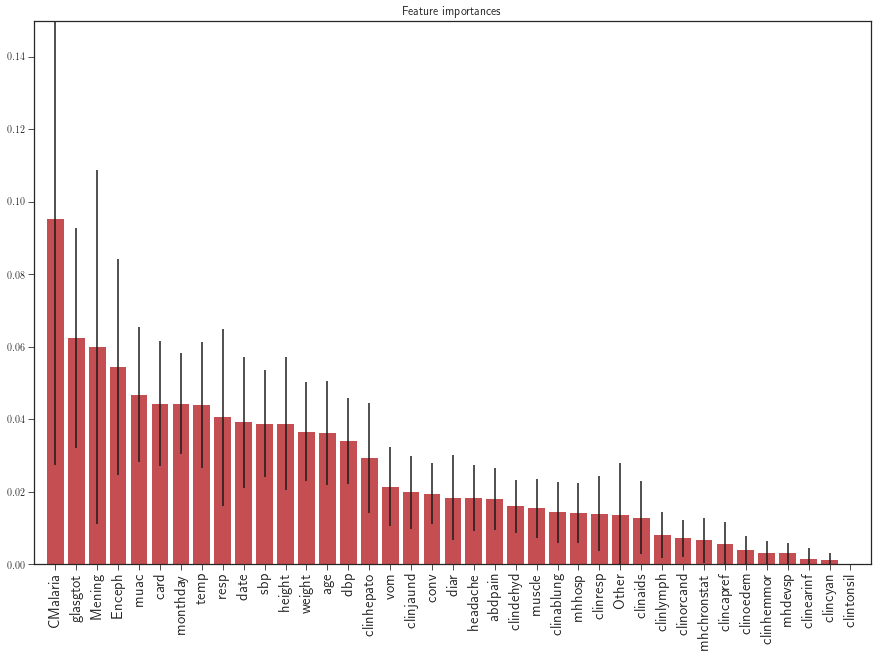

In [47]:
# Print the feature ranking
Xlabels = np.array(Xlabels)
PlotLabels = Xlabels[indices]
print("Feature ranking:")
#for full feature listing use this as the range: X.shape[1]
for f in range(10):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(15,10))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), PlotLabels, rotation='vertical',fontsize=15)
plt.xlim([-1, X.shape[1]])
plt.ylim(0,0.15)
plt.show()

In [48]:
#Make the predictions on the test data
y_pred_prob = forest.predict_proba(X_test)
y_pred = forest.predict(X_test)

In [52]:
#Print the confusion matrix:
confusion_matrix(y_test,y_pred)
classification_report(y_test,y_pred)

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


'             precision    recall  f1-score   support\n\n        0.0       0.79      0.88      0.83        48\n        1.0       0.25      0.11      0.15        19\n        2.0       0.00      0.00      0.00         5\n        3.0       0.00      0.00      0.00         2\n        5.0       0.54      0.70      0.61        46\n\navg / total       0.56      0.63      0.59       120\n'

In [53]:
#Because this is a random forest, the output is actually a probability of being in each class. So this is looking
#at the maximum probability for each test case - it gives us a sense of how confident the classifier is in each
#
probmax = np.amax(y_pred_prob,axis=1)
edges = np.linspace(0,1,101)

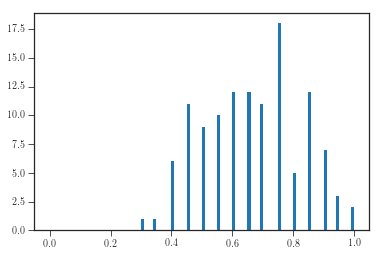

In [54]:
a,b,c = plt.hist(probmax,bins=edges)

In [55]:
edges

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])